# Energy Demand Forecasting with Granite Timeseries (TTM)

Based on the [Granite-Timeseries-TTM](https://github.com/ibm-granite/granite-tsfm/blob/cookbook-dev/notebooks/recipes/energy_demand_forecasting/demand_forecast_zeroshot_recipe.ipynb) notebook.

### Install the TSFM Library 

In [ ]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@main" -U

### Import Packages

In [2]:
import tsfm_public
import pandas as pd
tsfm_public.__version__

'0.2.9.dev37+gf856e5b'

In [3]:
from tsfm_public import (
    TinyTimeMixerForPrediction,
    TimeSeriesForecastingPipeline,
)
from tsfm_public.toolkit.visualization import plot_predictions

INFO:p-32083:t-8627749440:config.py:<module>:PyTorch version 2.2.2 available.


### Download the data

1. Download energy_data.csv.zip from Kaggle [here](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather)
2. Edit the `DATA_FILE_PATH` below to point to the data file.


In [4]:
DATA_FILE_PATH = "~/Downloads/energy_dataset.csv.zip"

### Specify time and output variables


In [5]:
timestamp_column = "time"
target_columns = ["total load actual"]
context_length = 512 # This is set by the pretrained model we will use.

### Read in the data

In [6]:
# Read in the data from the downloaded file.
input_df = pd.read_csv(
  DATA_FILE_PATH,
  parse_dates=[timestamp_column] # Convert the timestamp column to datetime format. 
)

# Fill NA/NaN values by propagating the last valid value.
input_df = input_df.ffill()

# Only use the last `context_length` rows for prediction.
input_df = input_df.iloc[-context_length:,]
input_df[timestamp_column] = pd.to_datetime(input_df[timestamp_column])

# Show the last few rows of the dataset.
input_df.tail()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89
35063,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3651.0,26.0,NaN,3117.0,24424.0,24455.0,64.27,69.88


### Plot a segment of the target series

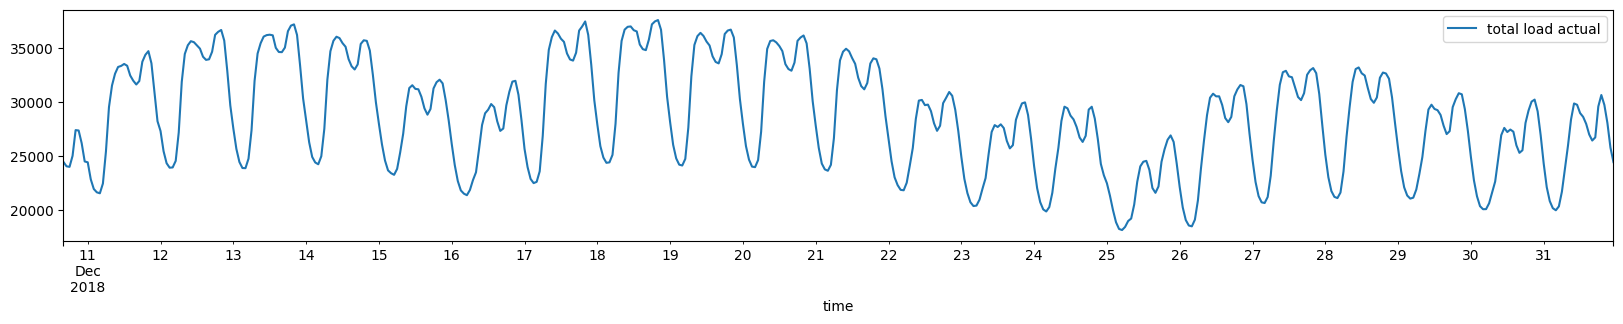

In [8]:
for target_column in target_columns:
  input_df.plot(x=timestamp_column, y=target_column, figsize=(20, 3))


### Set up zero shot model
The TTM model is hosted on [HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1).

In [9]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
  "ibm-granite/granite-timeseries-ttm-v1", # Name of the model on HuggingFace.
  num_input_channels=len(target_columns) # tsp.num_input_channels,
)

### Create a forecasting pipeline

In [16]:
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    explode_forecasts=True,
    freq="h",
    device="cpu", # Specify your local GPU or CPU.
)

zeroshot_forecast = pipeline(input_df)
zeroshot_forecast.tail()

,time,total load actual_prediction
91,2019-01-04 19:00:00+01:00,31888.007812
92,2019-01-04 20:00:00+01:00,31953.996094
93,2019-01-04 21:00:00+01:00,31226.650391
94,2019-01-04 22:00:00+01:00,29632.423828
95,2019-01-04 23:00:00+01:00,27261.152344


### Plot predictions along with the historical data.

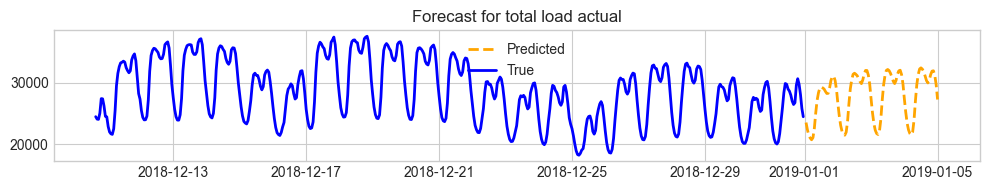

In [13]:
plot_predictions(
    input_df=input_df,
    exploded_predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_column,
    indices=[-1], # Plot the last prediction series.
    num_plots=1,
)